In [9]:
# Import the organization modules
import pandas as pd
import numpy as np
# Import module to ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Import the plot modules
import matplotlib.pyplot as plt
import seaborn as sns
# Import own scripts
from scripts.data_cleaning import (
    read_all_csvs, 
    clean_data,
    create_csv
    )

In [13]:
# Imports
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, fbeta_score, get_scorer_names

from xgboost import XGBClassifier

In [10]:
# Create data frame from all single CSV files
df = read_all_csvs()
# Clean the data
df = clean_data(df)

In [12]:
features = df.columns.to_list()
features.remove('state')
X = df[features]
y = df.state


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [15]:
y_train = np.where(y_train == "successful", 1, 0)

In [16]:
y_test = np.where(y_test == "successful", 1, 0)

In [17]:
# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(MinMaxScaler(), XGBClassifier())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [18]:
print("f_beta_score: ", fbeta_score(y_test, y_pred, beta = 2, average = 'macro').round(2))

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)

f_beta_score:  0.81
Accuracy on train set: 0.82
Accuracy on test set: 0.81
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     25014
           1       0.85      0.78      0.81     28378

    accuracy                           0.81     53392
   macro avg       0.81      0.81      0.81     53392
weighted avg       0.81      0.81      0.81     53392

--------------------------------------------------------------------------------


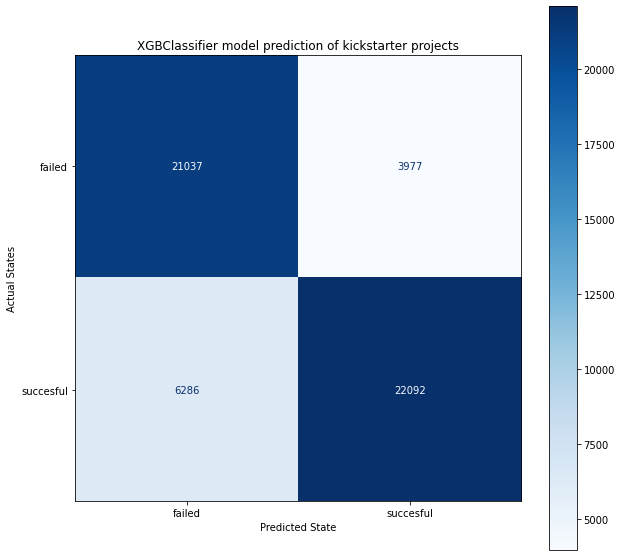

In [20]:
## Create the Confusion Matrix Display Object(cmd_obj)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['failed', 'succesful'])
## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
fig, ax = plt.subplots(figsize=(10,10))

## Set the color
cmd_obj.plot(ax=ax, cmap = 'Blues')
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='XGBClassifier model prediction of kickstarter projects', 
                xlabel='Predicted State', 
                ylabel='Actual States',
                )
## Finally, call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.show()